### To Use the Code in Google Colab

To run the notebooks and access the data in Google Colab, follow these steps:

1. **Create a Google account** if you don't already have one. This gives you access to both Colab and Google Drive.

2. **Use the shared link** provided to you to copy (clone) the notebooks into your own Google Drive.

3. **Download the corpora and exercise files** from the link provided, and upload them to your Google Drive.

4. **Grant Colab access to your Google Drive** by running the following code:

```python
from google.colab import drive
drive.mount('/content/drive')
```


5. **You can now easily read files from your Google Drive** using standard file paths.

---
---

In [ ]:
# Uncomment when you use colab
# from google.colab import drive
# drive.mount('/content/drive')

In [28]:
# Standard library imports
import os
import string
import re

# Data handling
import pandas as pd

# Natural Language Processing
import nltk
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
import unicodedata  # For accent removal
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from wordcloud import WordCloud


# Visualization
import matplotlib.pyplot as plt
import seaborn as sns


In [4]:
from IPython.display import clear_output
import time
def countdown_timer(seconds):
    for i in range(seconds, -1, -1):
        clear_output(wait=True)
        print(f"⏳ Time remaining: {i} seconds")
        time.sleep(1)
    print("✅ Time's up!")

In [5]:
# Download the necessary resources
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to F:\Mahdi\Dropbox\Dropbox\code
[nltk_data]     \courseTeach\.venv\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to F:\Mahdi\Dropbox\Dropbox\co
[nltk_data]     de\courseTeach\.venv\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to F:\Mahdi\Dropbox\Dropbox\co
[nltk_data]     de\courseTeach\.venv\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to F:\Mahdi\Dropbox\Dropbox\
[nltk_data]     code\courseTeach\.venv\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
stop_words = set(nltk.corpus.stopwords.words('english'))
punctuations = set(string.punctuation)

In [1]:
# Initialize stemmer
lemmatizer = WordNetLemmatizer()
vectorizer = CountVectorizer()

NameError: name 'WordNetLemmatizer' is not defined

# Session 2 – Bag of Words Representation of Text

In this session, we introduce the **Bag of Words (BoW)** model—one of the most fundamental techniques for representing text numerically.

### Objectives:

- Understand how the **Bag of Words (BoW)** model works
  - Convert text into a **document-term matrix** based on word counts
  - Learn about key preprocessing steps: lowercasing, tokenization, stopword and punctuation removal, lemmatization
  - Apply frequency filtering to remove extremely rare or overly common words

- Explore the **Dictionary Approach** in text analysis
  - Use predefined sets of words (dictionaries) to detect themes or categories in text
  - Understand how dictionary-based methods can classify documents into categories

- Apply **Sentiment Analysis** as a real-world example of the dictionary approach
  - Use sentiment lexicons to quantify emotional tone in text
  - Compute and compare **polarity** (positive/negative) and **subjectivity** (objective/subjective) scores across documents

This session provides the foundation for more advanced representations (such as TF-IDF and embeddings) and introduces simple, interpretable methods for analyzing meaning in text.

## 2.1. Document - Feature Matrix

### We need to represent words as numbers.
Two common approaches are:

    Bag of Words (BoW)

    Word Embeddings

The simplest method is the Bag of Words approach, which counts how many times each word appears in a document.

### Bag of Words (BoW) Representation: Steps

1. **Read the document.**
2. **Convert all words to lowercase.**
   Ensures consistency (e.g., "Apple" and "apple" are treated the same).

3. **Remove punctuation.**
   Removes characters like `.,!?` that don't contribute to meaning.

4. **Remove stop words.**
   Filters out common words like "the", "is", and "and".

5. **Create equivalence classes (vocabulary).**
   Extract a list of unique words that will be used as features.

6. **Filter by frequency (optional).**
   Remove very rare or overly common words to reduce dimensionality and noise.


---
---

### Example 1 – BoW Representation: Steps 1 and 2

In this example, we demonstrate the first two steps of the Bag of Words (BoW) process:

1. **Read the document** – Load or define a sample text.
2. **Convert all words to lowercase** – Normalize the text so that words like "Dog" and "dog" are treated the same.


In [11]:
# Step 1: Read the documents and store content in a dictionary

# Create an empty dictionary to hold file names and their corresponding text
dictUNSpeech = {}

# Define the directory containing the speech files
fileAddress1 = '../../corpusExample/unSpeeches2000_2010'

# Loop through each file in the directory
for file in os.listdir(fileAddress1):
    # Open each file using UTF-8 encoding (replace errors if any)
    with open(os.path.join(fileAddress1, file), 'r', encoding='utf-8', errors='replace') as textFile:
        # Store the file content in the dictionary using the filename (without .txt) as the key
        dictUNSpeech[file.replace('.txt', '')] = textFile.read()

# Convert the dictionary to a pandas DataFrame
dfUNSpeech = pd.DataFrame(list(dictUNSpeech.items()), columns=["id", "text"])

# Extract metadata from the 'id' field
# Each ID is assumed to follow the format: "ISOAlpha_Session_Year"

# Extract the ISO alpha-3 country code
dfUNSpeech["isoAlpha"] = dfUNSpeech["id"].str.split("_", n=2, expand=True)[0].astype(str)

# Extract the session number
dfUNSpeech["session"] = dfUNSpeech["id"].str.split("_", n=2, expand=True)[1].astype(int)

# Extract the year
dfUNSpeech["year"] = dfUNSpeech["id"].str.split("_", n=2, expand=True)[2].astype(int)


In [12]:
dfUNSpeech

,id,text,isoAlpha,session,year
0,AFG_55_2000,"On my way to the\nAssembly Hall, I was informe...",AFG,55,2000
1,AFG_56_2001,"﻿At the outset, on\nbehalf of the Government o...",AFG,56,2001
2,AFG_57_2002,﻿Not very far from here stood\ntwo towers that...,AFG,57,2002
3,AFG_58_2003,﻿There is no reality more\noppressive than the...,AFG,58,2003
4,AFG_59_2004,Nelson Mandela once\ndescribed his countryís t...,AFG,59,2004
...,...,...,...,...,...
2074,ZWE_61_2006,Let me begin my statement \nby echoing the sen...,ZWE,61,2006
2075,ZWE_62_2007,Allow me to congratulate \nMr. Kerim on his el...,ZWE,62,2007
2076,ZWE_63_2008,I wish to begin by joining \nthose who have co...,ZWE,63,2008
2077,ZWE_64_2009,Let me begin by extending \nour warmest congra...,ZWE,64,2009


In [15]:
# Step 3: Create the Document-Term Matrix (DTM)

# Apply the vectorizer to the 'text' column of the UN speech DataFrame
# This returns a sparse matrix of token counts for each document
dtm = vectorizer.fit_transform(dfUNSpeech['text'])

# Step 4: Convert the sparse matrix to a regular DataFrame
dfDTM = pd.DataFrame(dtm.toarray(), columns=vectorizer.get_feature_names_out())

# Add the document IDs back to the DataFrame for reference
dfDTM["id"] = dfUNSpeech["id"]

# Optional: Move the 'id' column to the front for readability
cols = dfDTM.columns.tolist()
cols = [cols[-1]] + cols[:-1]  # Put 'id' first, then all other columns
dfDTM = dfDTM[cols]

# Display the resulting Document-Term Matrix
dfDTM


,id,000,001,005,01,020,04,041,043,05,...,ìstandards,ìwe,île,œi,œone,œour,œresponsibility,œrightâ,œwith,štampar
0,AFG_55_2000,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,AFG_56_2001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,AFG_57_2002,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,AFG_58_2003,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,AFG_59_2004,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2074,ZWE_61_2006,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2075,ZWE_62_2007,2,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
2076,ZWE_63_2008,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2077,ZWE_64_2009,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


---
---

### Exercise 2.1

In [ ]:
countdown_timer(300)

---
---

### Example 2 – Preprocessing the Texts

The raw texts are quite messy and not immediately useful for analysis.

To solve these problems, we will develop our own preprocessor function step by step. The first three steps include:

1. **Lowercasing words** – to ensure consistency (e.g., "Apple" and "apple" are treated the same).
2. **Tokenizing** – splitting the text into individual words.
3. **Removing stopwords, punctuation, and numbers** – to reduce noise and focus on meaningful content.


In [19]:
# Step 1: Define a custom analyzer for CountVectorizer
def custom_preprocessor(text):
    # Lowercase the text and remove digits
    text = re.sub(r'\d+', '', text.lower())

    # Tokenize the text
    tokens = nltk.tokenize.word_tokenize(text)

    # Remove punctuation, stopwords, and non-alphabetic tokens
    tokens = [
        token
        for token in tokens
        if token.isalpha() and token not in stop_words and token not in punctuations
    ]
    return tokens

# Step 2: Create a CountVectorizer using the custom analyzer
vectorizer = CountVectorizer(analyzer=custom_preprocessor)

# Fit the vectorizer to the text and transform it into a DTM (sparse matrix)
dtm = vectorizer.fit_transform(dfUNSpeech["text"])

# Step 3: Convert the DTM to a DataFrame
dfDTM = pd.DataFrame(dtm.toarray(), columns=vectorizer.get_feature_names_out())

# Add the document ID as a separate column and move it to the front
dfDTM["id"] = dfUNSpeech["id"]
dfDTM = dfDTM[["id"] + dfDTM.columns[:-1].tolist()]

# Display the resulting document-term matrix
dfDTM.head(5)

,id,ab,ababa,abaco,abandon,abandoned,abandoning,abandonment,abandons,abashi,...,ìour,ìrectangular,ìresponsibility,ìstandards,ìwe,île,ñ,ó,ö,štampar
0,AFG_55_2000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,AFG_56_2001,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,AFG_57_2002,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,AFG_58_2003,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,AFG_59_2004,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2074,ZWE_61_2006,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2075,ZWE_62_2007,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2076,ZWE_63_2008,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2077,ZWE_64_2009,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Example 2 – Preprocessing the Texts

The raw texts are quite messy and not immediately suitable for analysis.

To clean and prepare the data, we will develop a custom preprocessor function step by step. The first four steps include:

1. **Lowercasing words** – to ensure consistency (e.g., "Apple" and "apple" are treated the same).
2. **Tokenizing** – splitting the text into individual words (tokens).
3. **Removing stopwords, punctuation, and numbers** – to reduce noise and keep only meaningful words.
4. **Lemmatizing words** – converting each word to its base or dictionary form (e.g., "running" → "run").

In [22]:
# Step 1: Define a custom analyzer for CountVectorizer
def custom_preprocessor(text):
    # Lowercase the text and remove digits
    text = re.sub(r'\d+', '', text.lower())

    # Tokenize the text
    tokens = nltk.tokenize.word_tokenize(text)

    # Remove punctuation, stopwords, and non-alphabetic tokens
    tokens = [
        lemmatizer.lemmatize(token)  # Lemmatize each word
        for token in tokens
        if token.isalpha() and token not in stop_words and token not in punctuations
    ]
    return tokens

# Step 2: Create a CountVectorizer using the custom analyzer
vectorizer = CountVectorizer(analyzer=custom_preprocessor)

# Fit the vectorizer to the text and transform it into a DTM (sparse matrix)
dtm = vectorizer.fit_transform(dfUNSpeech["text"])

# Step 3: Convert the DTM to a DataFrame
dfDTM = pd.DataFrame(dtm.toarray(), columns=vectorizer.get_feature_names_out())

# Add the document ID as a separate column and move it to the front
dfDTM["id"] = dfUNSpeech["id"]
dfDTM = dfDTM[["id"] + dfDTM.columns[:-1].tolist()]

# Display the resulting document-term matrix
dfDTM.head(5)

,id,ab,ababa,abaco,abandon,abandoned,abandoning,abandonment,abashi,abated,...,ìour,ìrectangular,ìresponsibility,ìstandards,ìwe,île,ñ,ó,ö,štampar
0,AFG_55_2000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,AFG_56_2001,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,AFG_57_2002,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,AFG_58_2003,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,AFG_59_2004,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2074,ZWE_61_2006,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2075,ZWE_62_2007,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2076,ZWE_63_2008,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2077,ZWE_64_2009,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Example 2 – Preprocessing the Texts

The raw texts are quite messy and not immediately suitable for analysis.

To clean and prepare the data, we will develop a custom preprocessor function step by step. The following steps are included:

1. **Lowercasing words** – to ensure consistency (e.g., "Apple" and "apple" are treated the same).
2. **Tokenizing** – splitting the text into individual words (tokens).
3. **Removing stopwords, punctuation, and numbers** – to reduce noise and keep only meaningful words.
4. **Lemmatizing words** – converting each word to its base or dictionary form (e.g., "running" → "run").
5. **Removing accents** – converting accented characters to their closest ASCII equivalents (e.g., "résumé" → "resume").


In [25]:
# Step 1: Define a custom analyzer for CountVectorizer
def custom_preprocessor(text):
    # Normalize and remove accents
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')

    # Lowercase the text and remove digits
    text = re.sub(r'\d+', '', text.lower())

    # Tokenize the text
    tokens = nltk.tokenize.word_tokenize(text)

    # Remove stopwords, punctuation, and non-alphabetic tokens
    tokens = [
        lemmatizer.lemmatize(token)  # Lemmatize each word
        for token in tokens
        if token.isalpha() and token not in stop_words and token not in punctuations
    ]
    return tokens

# Step 2: Create a CountVectorizer using the custom analyzer
vectorizer = CountVectorizer(analyzer=custom_preprocessor)  # strip_accents removed because it's now handled manually

# Fit the vectorizer to the text and transform it into a DTM (sparse matrix)
dtm = vectorizer.fit_transform(dfUNSpeech["text"])

# Step 3: Convert the DTM to a DataFrame
dfDTM = pd.DataFrame(dtm.toarray(), columns=vectorizer.get_feature_names_out())

# Add the document ID as a separate column and move it to the front
dfDTM["id"] = dfUNSpeech["id"]
dfDTM = dfDTM[["id"] + dfDTM.columns[:-1].tolist()]

# Display the resulting document-term matrix
dfDTM.head(5)


,id,ab,ababa,abaco,abandon,abandoned,abandoning,abandonment,abashi,abated,...,zone,zoning,zor,zoran,zuleta,zulfikar,zuma,zurich,zviad,zvornik
0,AFG_55_2000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,AFG_56_2001,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,AFG_57_2002,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,AFG_58_2003,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,AFG_59_2004,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


---
---

### Removing Words That Are Either Highly Rare or Highly Frequent

The goal of using word features is to **differentiate documents** from one another.

However:

- **Rare words** (that appear in only one or two documents) do not help us understand general patterns.
- **Highly frequent words** (that appear in almost every document) do not help us distinguish between texts.

To address this, we apply **document frequency filtering**:

- We keep only the words that appear in **at least a certain percentage** of the documents (e.g., 5%).
- We also remove words that appear in **more than a certain percentage** of documents (e.g., 85%).

This helps reduce noise and focus on more informative terms.

In [26]:
# Step 1: Define a custom analyzer for CountVectorizer
def custom_preprocessor(text):
    # Normalize and remove accents
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')

    # Lowercase the text and remove digits
    text = re.sub(r'\d+', '', text.lower())

    # Tokenize the text
    tokens = nltk.tokenize.word_tokenize(text)

    # Remove stopwords, punctuation, and non-alphabetic tokens; then lemmatize
    tokens = [
        lemmatizer.lemmatize(token)
        for token in tokens
        if token.isalpha() and token not in stop_words and token not in punctuations
    ]

    return tokens

# Step 2: Create a CountVectorizer using the custom analyzer
# - min_df=0.1: only keep terms that appear in at least 10% of documents
# - max_df=0.9: remove terms that appear in more than 90% of documents
vectorizer = CountVectorizer(
    analyzer=custom_preprocessor,
    min_df=0.1,
    max_df=0.9
)

# Fit the vectorizer to the speech texts and create a document-term matrix (DTM)
dtm = vectorizer.fit_transform(dfUNSpeech["text"])

# Step 3: Convert the sparse matrix to a DataFrame
dfDTM = pd.DataFrame(dtm.toarray(), columns=vectorizer.get_feature_names_out())

# Add document ID and move it to the first column
dfDTM["id"] = dfUNSpeech["id"]
dfDTM = dfDTM[["id"] + dfDTM.columns[:-1].tolist()]

# Display the first 5 rows of the document-term matrix
dfDTM.head(5)


,id,ability,able,accept,acceptable,accepted,access,accordance,according,account,...,word,work,working,worldwide,would,yesterday,yet,york,young,zone
0,AFG_55_2000,0,0,0,0,0,2,2,1,1,...,1,0,2,0,3,0,0,0,1,0
1,AFG_56_2001,0,1,0,0,0,0,0,0,0,...,0,2,0,0,2,1,0,0,1,0
2,AFG_57_2002,0,0,0,0,1,0,1,0,0,...,0,0,0,0,4,0,1,0,0,0
3,AFG_58_2003,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,1,0,1,0
4,AFG_59_2004,0,0,0,0,0,2,0,0,0,...,0,0,1,0,1,0,1,0,0,0


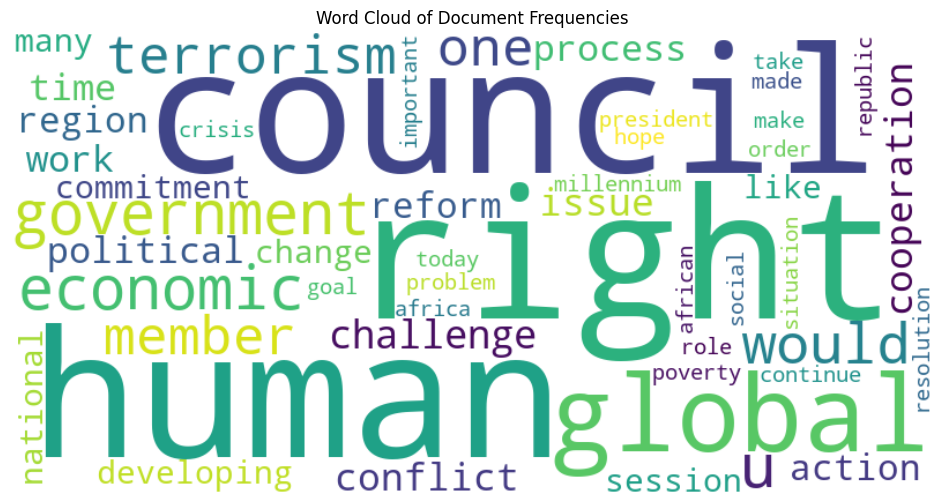

In [30]:
# Step 4: Sum the frequencies of each term across all documents
word_freq = dfDTM.drop(columns='id').sum().to_dict()

# Step 5: Generate and display the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=50).generate_from_frequencies(word_freq)

# Plot the word cloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Document Frequencies')
plt.show()


---
---

### Exercise 2.2

In [ ]:
countdown_timer(300)

---
---

# 2.2. Bag of Words - various Matrices

### Other Matrices

In addition to the basic **Bag of Words (BoW)** model, there are several other ways to represent text as numerical features:

- **Word Count**
  Counts how many times each word appears in a document.
  → This is the default output of `CountVectorizer`.

- **Term Frequency (TF)**
  Measures how frequently a term occurs in a document, normalized by the total number of terms in that document.

- **Term Frequency – Inverse Document Frequency (TF-IDF)**
  Combines term frequency with inverse document frequency to reduce the weight of common words and highlight more informative ones.

TF-IDF is particularly useful when you want to identify words that are **important in a specific document** but not common across all documents.


---
---

### Term Frequency (TF)

Term Frequency measures how often a word appears in a document, relative to the total number of words in that document.

The formula is:

$$
\text{Word\_Frequency}_{ij} = \frac{\text{Number of appearances of word } i}{\text{Total number of words in document } j}
$$

Where:
- \( i \) is the word (term)
- \( j \) is the document
- The numerator counts how many times word \( i \) appears in document \( j \)
- The denominator is the total number of words in document \( j \)

TF helps normalize word counts, so longer documents do not automatically have higher raw counts for all words.


### TF Features

Term Frequency (TF) normalizes raw word counts based on the length of the document.

- This allows us to **compare the importance of a word across documents of different lengths**.
- Without normalization, longer documents would naturally have higher word counts—even if a word is not especially important.

**Key Benefit:**
TF enables fair comparison of how frequently a word appears, regardless of document size.


### Example 1 - Term Frequency

In [31]:
import unicodedata  # For accent removal

# Step 1: Define a custom analyzer for CountVectorizer
def custom_preprocessor(text):
    # Normalize and remove accents
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')

    # Lowercase the text and remove digits
    text = re.sub(r'\d+', '', text.lower())

    # Tokenize the text
    tokens = nltk.tokenize.word_tokenize(text)

    # Remove stopwords, punctuation, and non-alphabetic tokens; then lemmatize
    tokens = [
        lemmatizer.lemmatize(token)
        for token in tokens
        if token.isalpha() and token not in stop_words and token not in punctuations
    ]

    return tokens

# Step 2: Create a CountVectorizer using the custom analyzer
# - min_df=0.1: keep words appearing in at least 10% of documents
# - max_df=0.9: exclude words appearing in more than 90% of documents
vectorizer = CountVectorizer(
    analyzer=custom_preprocessor,
    min_df=0.1,
    max_df=0.9
)

# Fit the vectorizer and transform text into a Document-Term Matrix (DTM)
dtm = vectorizer.fit_transform(dfUNSpeech["text"])

# Step 3: Convert the DTM to a DataFrame
dfDTM = pd.DataFrame(dtm.toarray(), columns=vectorizer.get_feature_names_out())

# Add document ID and move it to the front
dfDTM["id"] = dfUNSpeech["id"]

# Optional: Show the first 5 rows of raw word counts
# dfDTM.head(5)

# Step 4: Normalize to Term Frequency (TF)
# For each row (document), divide word counts by the total word count in that document
term_cols = vectorizer.get_feature_names_out()
dfDTM[term_cols] = dfDTM[term_cols].div(dfDTM[term_cols].sum(axis=1), axis=0)

# Ensure 'id' column remains first
dfDTM = dfDTM[["id"] + list(term_cols)]

# Final output: Document-Term Matrix with TF values
dfDTM.head(5)

,id,ability,able,accept,acceptable,accepted,access,accordance,according,account,...,word,work,working,worldwide,would,yesterday,yet,york,young,zone
0,AFG_55_2000,0.0,0.000000,0.0,0.0,0.000000,0.002448,0.002448,0.001224,0.001224,...,0.001224,0.000000,0.002448,0.0,0.003672,0.000000,0.000000,0.0,0.001224,0.0
1,AFG_56_2001,0.0,0.001647,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.003295,0.000000,0.0,0.003295,0.001647,0.000000,0.0,0.001647,0.0
2,AFG_57_2002,0.0,0.000000,0.0,0.0,0.001742,0.000000,0.001742,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.006969,0.000000,0.001742,0.0,0.000000,0.0
3,AFG_58_2003,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.001923,0.000000,0.0,0.001923,0.000000,0.001923,0.0,0.001923,0.0
4,AFG_59_2004,0.0,0.000000,0.0,0.0,0.000000,0.005291,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.002646,0.0,0.002646,0.000000,0.002646,0.0,0.000000,0.0


---
---

### Exercise 2.3

In [ ]:
countdown_timer(300)

---
---

### Term Frequency – Inverse Document Frequency (TF-IDF)

While **Term Frequency (TF)** tells us how often a word appears in a document, it does **not** account for how common that word is across all documents.

Words that appear in **every document** (like "country" or "government") are usually **not informative** for distinguishing between documents.

**TF-IDF** solves this problem by reducing the weight of common terms and increasing the weight of rare but meaningful ones.

The formula is:

\[
\text{TF-IDF}_{ij} = \text{TF}_{ij} \times \log\left(\frac{N}{df_i}\right)
\]

Where:
- $\text{TF}_{ij}$ is the term frequency of word \( i \) in document \( j \)
- $N$ is the total number of documents
- $df_i$ is the number of documents containing word \( i \)

This weighting helps highlight words that are **important in a specific document**, but **not common across all documents**.


### Example 2 - TF-IDF: Example

In [32]:
import unicodedata  # For accent removal

# Step 1: Define a custom analyzer for CountVectorizer
def custom_preprocessor(text):
    # Normalize and remove accents
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')

    # Lowercase the text and remove digits
    text = re.sub(r'\d+', '', text.lower())

    # Tokenize the text
    tokens = nltk.tokenize.word_tokenize(text)

    # Remove stopwords, punctuation, and non-alphabetic tokens; then lemmatize
    tokens = [
        lemmatizer.lemmatize(token)
        for token in tokens
        if token.isalpha() and token not in stop_words and token not in punctuations
    ]

    return tokens

# Step 2: Create a CountVectorizer using the custom analyzer
# - min_df=0.1: keep words appearing in at least 10% of documents
# - max_df=0.9: exclude words appearing in more than 90% of documents
tfidfVectorizer = TfidfVectorizer(
    analyzer=custom_preprocessor,
    min_df=0.1,
    max_df=0.9
)

# Fit the vectorizer and transform text into a Document-Term Matrix (DTM)
dtm = tfidfVectorizer.fit_transform(dfUNSpeech["text"])

# Step 3: Convert the DTM to a DataFrame
dfDTM = pd.DataFrame(dtm.toarray(), columns=tfidfVectorizer.get_feature_names_out())

# Add document ID and move it to the front
dfDTM["id"] = dfUNSpeech["id"]

# Optional: Show the first 5 rows of raw word counts
# dfDTM.head(5)

# Step 4: Normalize to Term Frequency (TF)
# For each row (document), divide word counts by the total word count in that document
term_cols = tfidfVectorizer.get_feature_names_out()
dfDTM[term_cols] = dfDTM[term_cols].div(dfDTM[term_cols].sum(axis=1), axis=0)

# Ensure 'id' column remains first
dfDTM = dfDTM[["id"] + list(term_cols)]

# Final output: Document-Term Matrix with TF values
dfDTM.head(5)

,id,ability,able,accept,acceptable,accepted,access,accordance,according,account,...,word,work,working,worldwide,would,yesterday,yet,york,young,zone
0,AFG_55_2000,0.0,0.000000,0.0,0.0,0.000000,0.002341,0.002743,0.001775,0.001363,...,0.001323,0.000000,0.002068,0.0,0.001921,0.000000,0.000000,0.0,0.001682,0.0
1,AFG_56_2001,0.0,0.001334,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.001894,0.000000,0.0,0.001776,0.002484,0.000000,0.0,0.002333,0.0
2,AFG_57_2002,0.0,0.000000,0.0,0.0,0.002627,0.000000,0.001993,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.003722,0.000000,0.001544,0.0,0.000000,0.0
3,AFG_58_2003,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.001113,0.000000,0.0,0.001044,0.000000,0.001731,0.0,0.002741,0.0
4,AFG_59_2004,0.0,0.000000,0.0,0.0,0.000000,0.005286,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.002335,0.0,0.001446,0.000000,0.002399,0.0,0.000000,0.0


---
---

### Exercise 2.4

In [ ]:
countdown_timer(300)

---
---

## 2.3. Dictionary Approach

### Dictionary Approach: Basic Idea

The dictionary approach is a type of **classification task** in text analysis.

In machine learning, a classification task refers to a problem where we assign observations to one of several **predefined groups or categories**.

#### Steps in the Dictionary Approach:

1. **Define your categories**
   - These should be clearly defined and mutually exclusive or exhaustive (e.g., "positive", "negative", "neutral").

2. **Assign related words to each category**
   - Build a dictionary where each category has a list of associated words (e.g., "happy", "joy" → positive).

3. **Choose a matrix representation**
   - For example: raw word counts, TF, or TF-IDF.

4. **Apply the dictionary to the matrix**
   - Calculate the total presence or weight of dictionary words in each document to assign or score categories.


### Example 1 - Dictionary Approach

In [33]:
def calculate_term_frequencies_with_sklearn(directory_path):

    dfMoralFoundation = pd.DataFrame()

    dictionary_path = "../../corpusExample/data/dicMFD"
    for dictionary_file in os.listdir(dictionary_path):
        if dictionary_file.endswith(".txt"):
            with open(os.path.join(dictionary_path, dictionary_file), 'r', encoding='utf-8') as file:
                dictionary_terms = [line.strip().lower() for line in file.read().splitlines()]

            dictionary_terms = list(set(dictionary_terms))

            filenames = []
            texts = []
            total_word_counts = []  
            

            for filename in os.listdir(directory_path):
                if filename.endswith(".txt"):  
                    file_path = os.path.join(directory_path, filename)


                    with open(file_path, 'r', encoding='utf-8', errors="ignore") as file:
                        terms = [line.strip().lower() for line in file.read().splitlines()]
                        content = file.read()

                    with open(file_path, 'r', encoding='utf-8', errors="ignore") as file:
                        content = file.read()
                        total_word_counts.append(len(content.split()))





                    texts.append(" ".join(terms))
                    filenames.append(filename.replace(".txt", ""))

            vectorizer = CountVectorizer(vocabulary=dictionary_terms)
            term_matrix = vectorizer.fit_transform(texts)


            term_df = pd.DataFrame(term_matrix.toarray(), index=filenames, columns=vectorizer.get_feature_names_out())

            term_df['term_count'] = term_df.sum(axis=1)

            term_df['relative_frequency'] = term_df['term_count'] / pd.Series(total_word_counts, index=filenames)

            DicName = dictionary_file.replace(".txt", "")
            dfMoralFoundation[f'{DicName}_abs'] = term_df['term_count']
            dfMoralFoundation[f'{DicName}_rel'] = term_df['relative_frequency']

    return dfMoralFoundation

In [35]:
# Define the path to the directory containing UN speech text files
text_directory_path = "../../corpusExample/unSpeeches2000_2010"

# Step 1: Calculate term frequencies using a custom function
# Assumes that 'calculate_term_frequencies_with_sklearn()' returns a DataFrame
# with speech IDs as the index and term frequencies as features
dfUNSpeechMFD = calculate_term_frequencies_with_sklearn(text_directory_path)

# Step 2: Reset index to move speech ID from index to a column
dfUNSpeechMFD.reset_index(inplace=True)

# Step 3: Extract metadata (country code, session number, year) from the filename
# Example filename format: "USA_65_2010"

# Split the 'index' column once and assign all three new columns at once for efficiency
meta = dfUNSpeechMFD["index"].str.split("_", n=2, expand=True)
dfUNSpeechMFD["isoAlpha"] = meta[0].astype(str)
dfUNSpeechMFD["session"] = meta[1].astype(int)
dfUNSpeechMFD["year"] = meta[2].astype(int)

# Final result: Term frequency matrix with document metadata
dfUNSpeechMFD

,index,authority_abs,authority_rel,care_abs,care_rel,fairness_abs,fairness_rel,loyalty_abs,loyalty_rel,sanctity_abs,sanctity_rel,isoAlpha,session,year
0,AFG_55_2000,14,0.004873,16,0.005569,8,0.002785,59,0.020536,25,0.008702,AFG,55,2000
1,AFG_56_2001,18,0.008683,14,0.006753,6,0.002894,74,0.035697,12,0.005789,AFG,56,2001
2,AFG_57_2002,13,0.007647,28,0.016471,14,0.008235,49,0.028824,6,0.003529,AFG,57,2002
3,AFG_58_2003,12,0.007421,20,0.012369,11,0.006803,37,0.022882,6,0.003711,AFG,58,2003
4,AFG_59_2004,7,0.006387,15,0.013686,4,0.003650,31,0.028285,3,0.002737,AFG,59,2004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2074,ZWE_61_2006,18,0.007592,16,0.006748,9,0.003796,67,0.028258,5,0.002109,ZWE,61,2006
2075,ZWE_62_2007,24,0.011696,17,0.008285,33,0.016082,51,0.024854,13,0.006335,ZWE,62,2007
2076,ZWE_63_2008,20,0.011111,21,0.011667,8,0.004444,47,0.026111,18,0.010000,ZWE,63,2008
2077,ZWE_64_2009,15,0.008711,6,0.003484,5,0.002904,51,0.029617,7,0.004065,ZWE,64,2009


### Example 2 – A First Look at the Data

Before diving deeper into text analysis, we take an initial look at the structure and content of our data.


### Descriptive Statistics of the Term Frequency Matrix

We use `.describe()` to view basic statistics (count, mean, standard deviation, min, max, etc.)
for each numeric column in the term frequency matrix.

This gives us a sense of:
- The overall distribution of term frequencies across all documents
- The relative sparsity or dominance of certain terms


In [36]:
# Display summary statistics for term frequency columns
dfUNSpeechMFD.describe()

,authority_abs,authority_rel,care_abs,care_rel,fairness_abs,fairness_rel,loyalty_abs,loyalty_rel,sanctity_abs,sanctity_rel,session,year
count,2079.000000,2079.000000,2079.000000,2079.000000,2079.000000,2079.000000,2079.000000,2079.000000,2079.000000,2079.000000,2079.000000,2079.000000
mean,15.415103,0.007959,17.069745,0.008824,9.898990,0.005142,52.577201,0.027614,7.033189,0.003612,60.042328,2005.042328
std,7.565968,0.002877,9.131825,0.003726,6.823316,0.003123,20.494270,0.007770,6.554896,0.002907,3.149184,3.149184
min,1.000000,0.000623,0.000000,0.000000,0.000000,0.000000,6.000000,0.005025,0.000000,0.000000,55.000000,2000.000000
25%,10.000000,0.005897,11.000000,0.006281,5.000000,0.002875,38.500000,0.022227,3.000000,0.001826,57.000000,2002.000000
50%,14.000000,0.007673,16.000000,0.008361,9.000000,0.004657,50.000000,0.026974,6.000000,0.003016,60.000000,2005.000000
75%,19.000000,0.009585,22.000000,0.010941,13.000000,0.006809,64.000000,0.032411,9.000000,0.004526,63.000000,2008.000000
max,89.000000,0.027382,125.000000,0.027010,70.000000,0.023398,361.000000,0.060976,86.000000,0.040728,65.000000,2010.000000


We group the term frequency matrix by different metadata columns—such as country, session, and year—
to explore how the average usage of terms varies across these dimensions.


In [37]:
# Step 1: Select only numeric columns (integers and floats)
# These are the term frequency features; metadata like 'id' is excluded
numeric_columns = dfUNSpeechMFD.select_dtypes(include='number').columns

# Step 2: Compute average term frequencies by country (isoAlpha)
countryMFD = dfUNSpeechMFD.groupby('isoAlpha')[numeric_columns].mean().reset_index()

# Step 3: Compute average term frequencies by session
sessionMFD = dfUNSpeechMFD.groupby('session')[numeric_columns].mean()

# Step 4: Compute average term frequencies by year
yearMFD = dfUNSpeechMFD.groupby('year')[numeric_columns].mean()


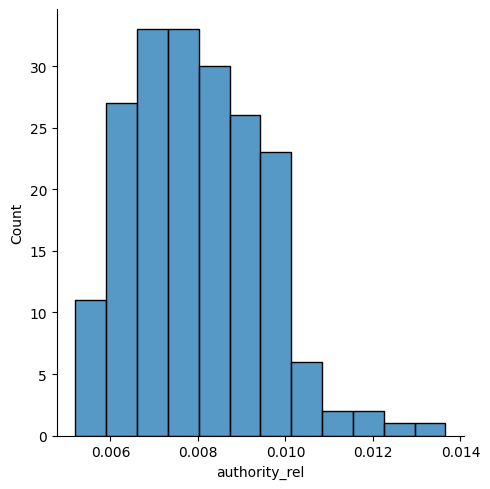

In [38]:
sns.displot(countryMFD, x='authority_rel')

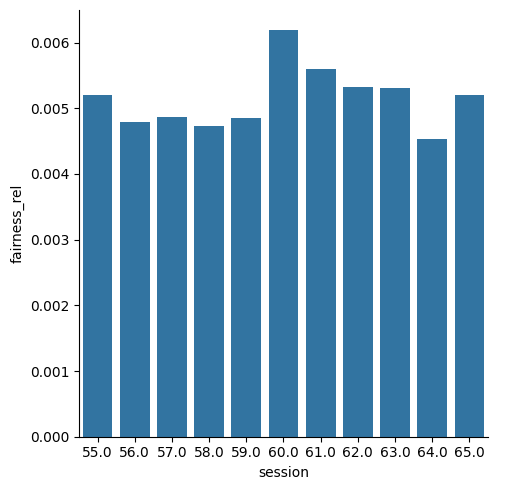

In [39]:
sns.catplot(sessionMFD, x='session', y='fairness_rel', kind='bar')

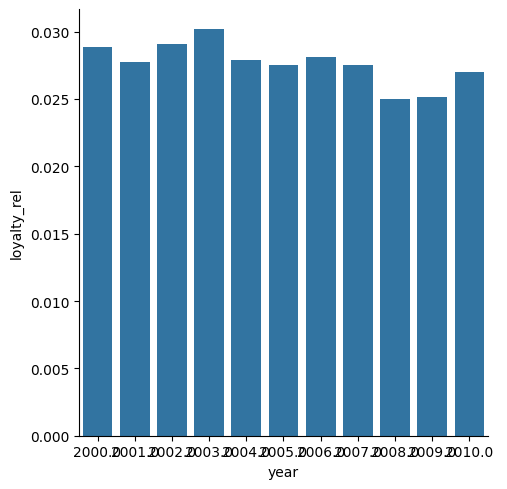

In [40]:
sns.catplot(yearMFD, x='year', y='loyalty_rel', kind='bar')

### 2.4: Sentiment Analysis as an Example of the Dictionary Approach

**Sentiment analysis** is a common example of the dictionary-based approach in text analysis.

- It uses **predefined lists of words** (dictionaries) that are associated with specific sentiments (e.g., positive or negative).
- Each document is scored based on how many sentiment-bearing words it contains.
- The overall sentiment of the document is then inferred from the balance of positive and negative terms.

This is a classification task where the categories are usually:
- **Positive**
- **Negative**
- (Sometimes) **Neutral**

We will now use sentiment dictionaries to analyze the emotional tone of our UN speeches.

### Example 1 - Sentiment Analysis

In [42]:
# Step 1: Define a function to extract sentiment metrics from a given text
def get_sentiment(text):
    blob = TextBlob(text)
    polarity = blob.sentiment.polarity        # Ranges from -1 (very negative) to +1 (very positive)
    subjectivity = blob.sentiment.subjectivity  # Ranges from 0 (objective) to 1 (subjective)
    return pd.Series([polarity, subjectivity])

# Step 2: Apply sentiment analysis to each speech
# The result will be two new columns: 'polarity' and 'subjectivity'
dfUNSpeech[['polarity', 'subjectivity']] = dfUNSpeech['text'].apply(get_sentiment)


In [43]:
# Step: Group speeches and compute average sentiment by country, session, and year

# Average sentiment (polarity and subjectivity) by country
countryMFDSentiment = dfUNSpeech.groupby('isoAlpha')[['polarity', 'subjectivity']].mean().reset_index()

# Average sentiment by UN session
sessionMFDSentiment = dfUNSpeech.groupby('session')[['polarity', 'subjectivity']].mean()

# Average sentiment by year
yearMFDSentiment = dfUNSpeech.groupby('year')[['polarity', 'subjectivity']].mean()


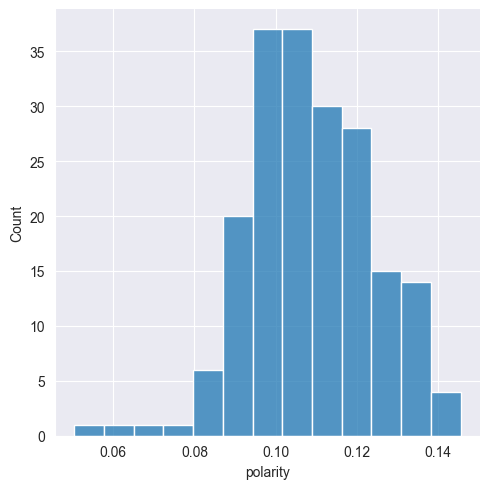

In [44]:
sns.displot(countryMFDSentiment, x='polarity')

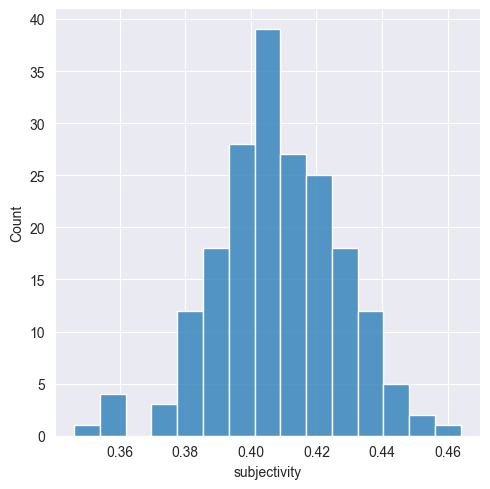

In [45]:
sns.displot(countryMFDSentiment, x='subjectivity')

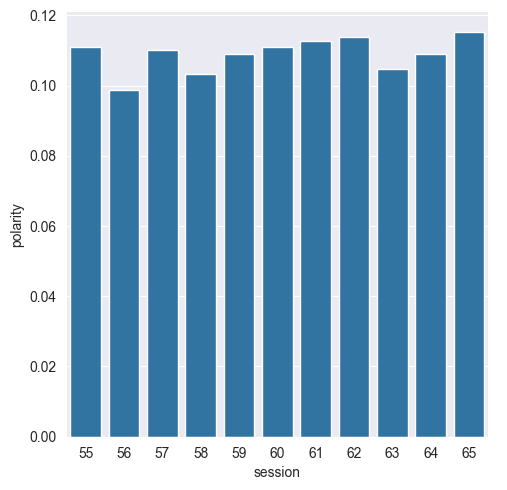

In [46]:
sns.catplot(sessionMFDSentiment, x='session', y='polarity', kind='bar')

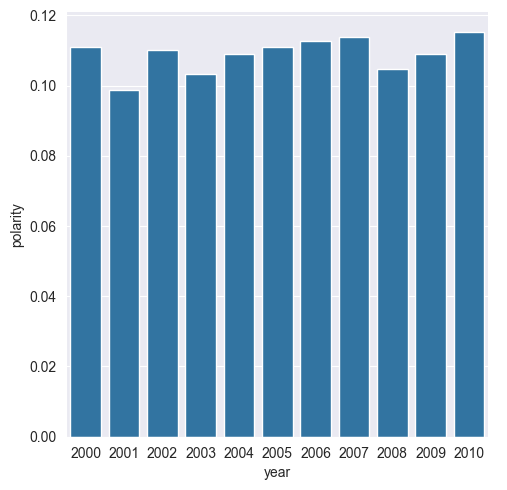

In [47]:
sns.catplot(yearMFDSentiment, x='year', y='polarity', kind='bar')